<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/split-step-fourier-method-1D-bis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # allows vectorized operations

import cupy as cp # fork of numpy
# allows vectorized operations on GPU

import time

import matplotlib.pyplot as plt
# plot style parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7f9fc'

In [0]:
################### Physical Parameters  ########################
Ip = 4**2; # peak intensity               
Ib = 1.0; # background illumination                       
Lambda = 0.651e-6; # wavelength
k0 = 2*np.pi/Lambda; # vacuum wavevector                 
n0 = 1; # background index of refraction      
Lz = 0.12; # computational length of sample    
Lx = 40e-3; # computational width of sample          

w0 = 0.25e-3 # beam width of gaussian beam parameter

In [0]:
################## Computational Parameters #############
nstepx = 2024*32; # number of transverse grid points
nstepz = 1024; # number of longitudinal propagation steps

deltax = Lx/nstepx;
deltaz = Lz/nstepz; # resolution in the z direction, IMPORTANT
deltaf = 1/Lx; # spatial frequency step       

In [7]:
print(f"Delta X: {deltax}")

Delta X: 6.175889328063241e-07


In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = cp.arange(0, Lz+deltaz, deltaz) # z array            
x = -Lx/2 +(cp.arange(0, nstepx, 1))*deltax; # x array               

In [0]:
##########################  Dispersive Step Setup #########################
# this is to get rid of fftshifts and the sort

ntx = 0;             
kx = cp.zeros(nstepx)                                          
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*cp.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

In [0]:
####################### INPUT FIELDS DEFINITION  #########################
# gaussian beam
InputField = cp.sqrt(Ip)*cp.exp(-(x**2)/(w0**2));

InputPower = cp.abs(InputField)**2

ValueError: ignored

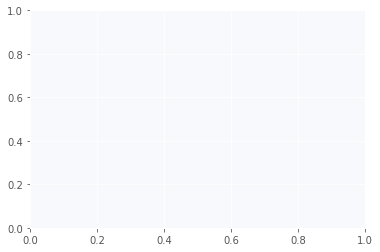

In [12]:
from matplotlib.colors import LinearSegmentedColormap
'''
To make more realistic plots we define a function
returning approzimated colormap from wavelength.
There is not a simple form for it, because of the
complex mechanisms of human vision and trichromy.
The physical model of colors mixing is achieved 
by summing values in RGB and clipping the results at 1.
'''
def wavelength_to_rgb(wavelength):
    '''
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wl = float(wavelength)
    if wl < 380: wl = 380
    if wl > 750: wl = 750
    if wl >= 380 and wl <= 440:
        att = 0.3 + 0.7 * (wl - 380) / (440 - 380) # attenuation
        R, G, B = ((-(wl - 440) / (440 - 380)) * att), 0, (1.0 * att)
    elif wl >= 440 and wl <= 490:
        R, G, B = 0.0, ((wl - 440) / (490 - 440)), 1
    elif wl >= 490 and wl <= 510:
        R, G, B = 0.0, 1, (-(wl - 510) / (510 - 490))
    elif wl >= 510 and wl <= 580:
        R, G, B = ((wl - 510) / (580 - 510)), 1, 0
    elif wl >= 580 and wl <= 645:
        R, G, B = 1.0, (-(wl - 645) / (645 - 580)), 0
    elif wl >= 645 and wl <= 750:
        att = 0.3 + 0.7 * (750 - wl) / (750 - 645)
        R, G, B = (1.0 * att), 0, 0
    else:
        R, G, B = 0, 0, 0
    return cp.asarray([R, G, B])

def wavelength_to_cmap(wavelength):
  R, G, B = wavelength_to_rgb(wavelength)
  cdict = {
        'red':  [[0.0,  0.0, 0.0],
                  [1.0,  R, R]],
        'green': [[0.0,  0.0, 0.0],
                  [1.0,  G, G]],
        'blue':  [[0.0,  0.0, 0.0],
                  [1.0,  B, B]]
            }
  return LinearSegmentedColormap('Cmap', segmentdata=cdict, N=256)

wavelengths = np.linspace(380, 750, 100) # in nanometers
rgbs = np.stack([wavelength_to_rgb(wl) for wl in wavelengths])
plt.plot(wavelengths, rgbs[:, 0], "r-")
plt.plot(wavelengths, rgbs[:, 1], "g-")
plt.plot(wavelengths, rgbs[:, 2], "b-")
plt.xlabel("wavelength (nm)")
plt.ylabel("RGB values")
plt.title("Wavelength vs. RGB values")
plt.show()

In [0]:
cmap = wavelength_to_cmap(Lambda*1e9) #light at the wavelength used in our experiment

In [0]:
# we define a function to plot 
def plot(Power, figsize=(15, 15), width=40, unit="mm", _cmap=cmap):
  if type(Power)==cp.core.core.ndarray:
    Power = cp.asnumpy(Power)
  fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  ax.imshow(Power, cmap=_cmap, extent=[-width,width,-width,width], vmin=0)
  return fig, ax

TypeError: ignored

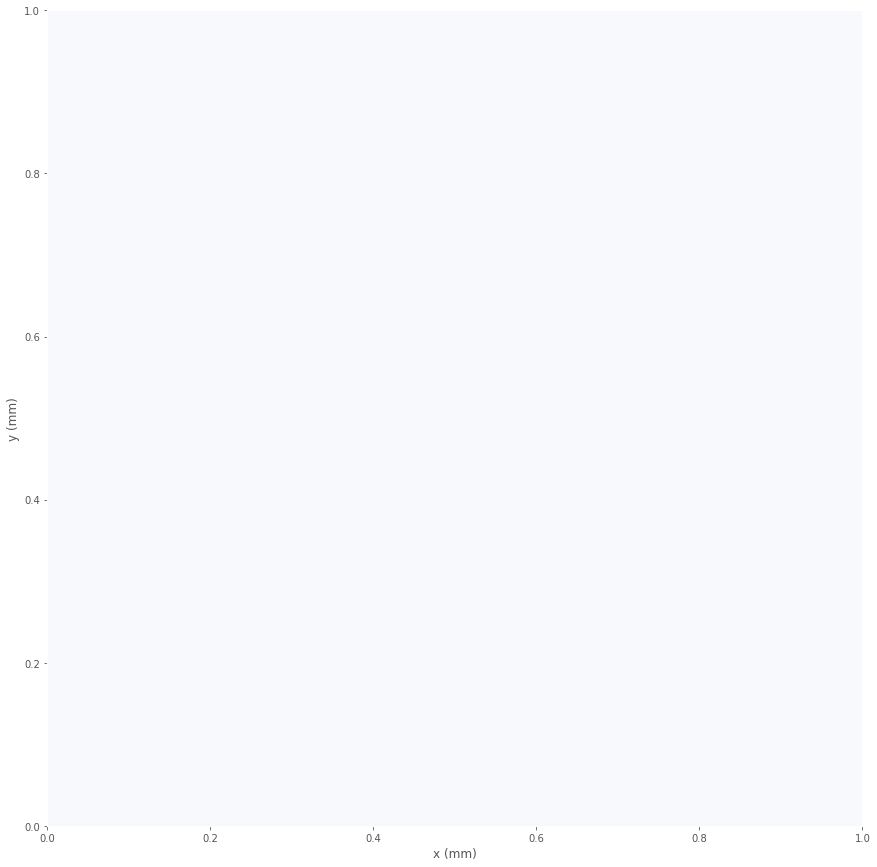

In [0]:
plot(InputPower)

In [0]:
fft, ifft = cp.fft.fft, cp.fft.ifft # faster with big matrices

In [0]:
######                    PROPAGATION LOOP                  ########

def propagate(Field, k, nstepz=nstepz, deltaz=deltaz, keep_memory=False):
  if keep_memory:
    # keeps a record of field module at every step
    FieldModuleMemory = cp.zeros(shape=(nstepx, nstepz+1))
    FieldModuleMemory[..., 0] = cp.abs(InputField)
  else:
    FieldModuleMemory = None
  ArgumentOfPropagator  = ((k*n0)**(-1)*(kx**2))*(deltaz/2);             
  Propagator = cp.exp(1j*ArgumentOfPropagator)
  tstart = time.time()
  for hh in range(nstepz):
      
      FieldTransform = fft(Field)*Propagator
      Field = ifft(FieldTransform)

      if keep_memory:
        FieldModuleMemory[..., 1+hh] = cp.abs(Field)

  print(f"Lasted {time.time()-tstart} seconds")
  return Field, FieldModuleMemory

In [0]:
OutputField, FieldModuleMemory = propagate(InputField, k0, keep_memory=True)
OutputPower = np.abs(OutputField)**2

OutputTotalPower = np.sum(OutputPower) # total power on output plane
InputTotalPower = np.sum(InputPower) # total power on input plane
gap = (OutputTotalPower-InputTotalPower)/(OutputTotalPower+InputTotalPower)

if abs(gap) > 1e-14:
  print(gap)

Lasted 0.05474376678466797 seconds


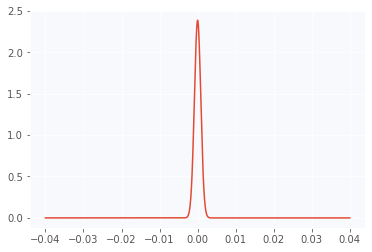

In [0]:
plt.plot(x, OutputPower)

In [0]:
# we evaluate an estimation of error due to low z resolution
estimate_error = False
if estimate_error:
  high_res_field = np.abs(propagate(InputField, k0, nstepz=200, deltaz=Lz/200))
  low_res_field = np.abs(propagate(InputField, k0, nstepz=20, deltaz=Lz/20))
  error = np.abs(low_res_field-high_res_field)
  max_error = np.max(error)
  print(f"Max_error: {max_error}")

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f999133d748>)

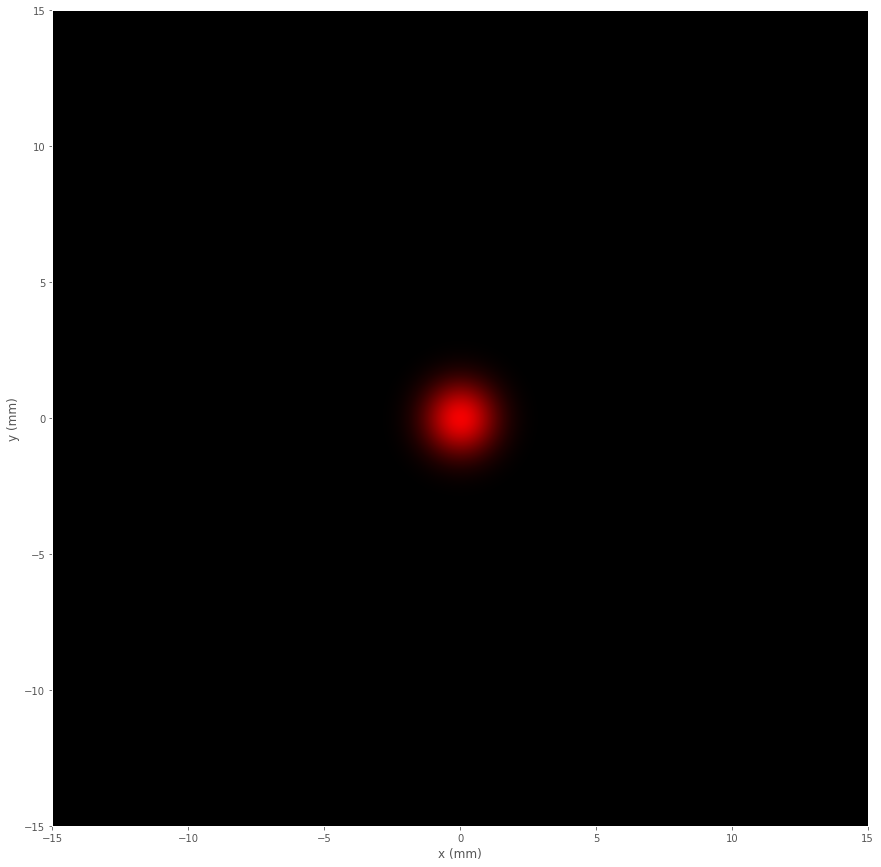

In [0]:
plt.close()
plot(OutputPower)

In [0]:
def propagate_and_get_rgb(InputField, wavelength):
  k = 2*np.pi/(wavelength) 
  OutputField = propagate(InputField, k)[0]
  P = cp.abs(OutputField)**2
  if P.ndim == 1:
    P = cp.stack((cp.abs(OutputField)**2,)*100, axis=0)
  rgb = cp.stack((P,)*3, axis=-1)/cp.max(P)
  return rgb*wavelength_to_rgb(wavelength*1e9)

Lasted 0.02622199058532715 seconds
Lasted 0.020496368408203125 seconds


(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f99912eb898>)

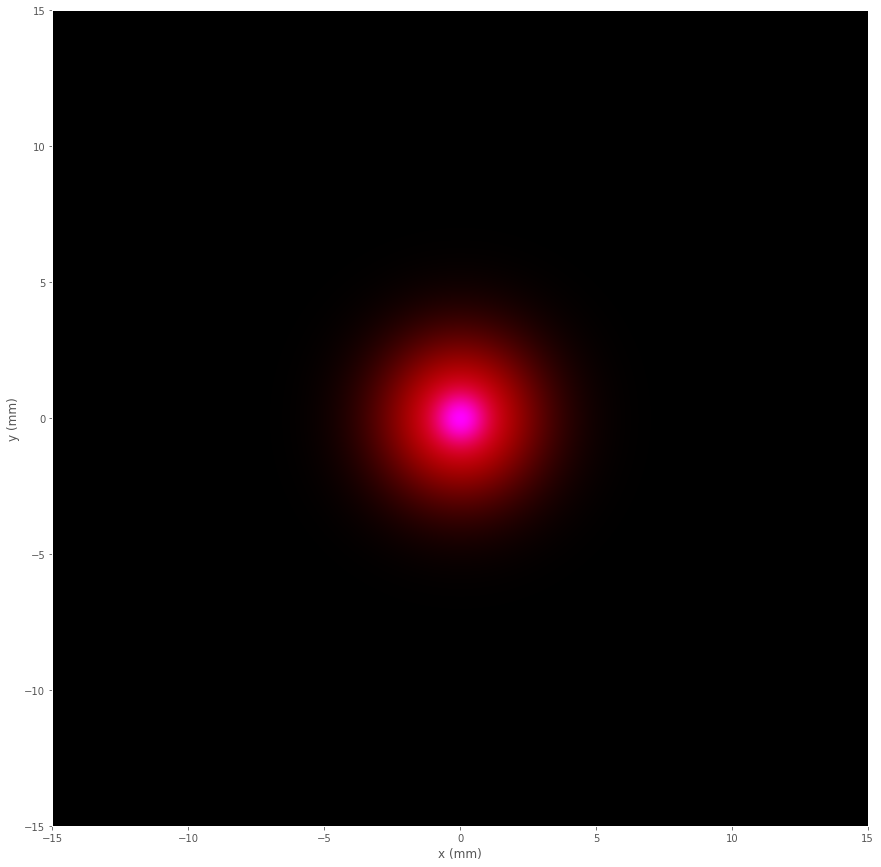

In [0]:
InputField1 = np.sqrt(Ip)*np.exp(1j*Chirp*X-((X-xshift)**2+(Y)**2)/(49*w0**2)); #7x larger
InputField2 = np.sqrt(Ip)*np.exp(1j*Chirp*X-((X-xshift)**2+(Y)**2)/(w0**2));

RedPower = propagate_and_get_rgb(InputField1, 0.645e-6)
BluePower = propagate_and_get_rgb(InputField, 0.44e-6)
plot(RedPower + BluePower) #purple point with red cirle 
# red + blue = purple

In [0]:
# we evaluate beam widths as the 2nd moment of a gaussian function

# extends grids X and Y to a third axis
# in order to make possible multiplying by FieldModuleMemory
_X = np.stack((X,)*(nstepz+1), axis=-1)
_Y = np.stack((Y,)*(nstepz+1), axis=-1)

norms = np.sum(FieldModuleMemory, axis=(0, 1))
widths = np.sqrt(np.sum((_X**2+_Y**2)*FieldModuleMemory, axis=(0, 1))/norms)

ValueError: ignored

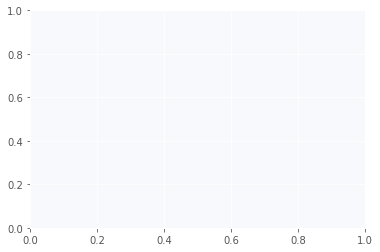

In [0]:
plt.scatter(z, 1000*widths)
z0 = k0*w0**2/2 # Rayleigh's width
plt.plot(_z, 1000*w0*np.sqrt(1+_z**2/z0**2))
plt.xlabel("z (m)")
plt.ylabel("width (mm)")
plt.title("Gaussian beam width during propagation")
plt.show()

In [0]:
PlaneInputField = 0*x
dist = 5e-6 #6.5e-6
width = 1e-6 #1.5e-6

N = 100
PlaneInputField += cp.sqrt(Ip)*(cp.exp(-(x)**20/(width**20)))
for n in range(1, N+1):
  PlaneInputField += cp.sqrt(Ip)*(cp.exp(-(x-n*dist)**20/(width**20))+cp.exp(-(x+n*dist)**20/(width**20)))

w0 = 0.25e-3
PlaneInputField = PlaneInputField * cp.exp(-(x)**2/(w0**2))

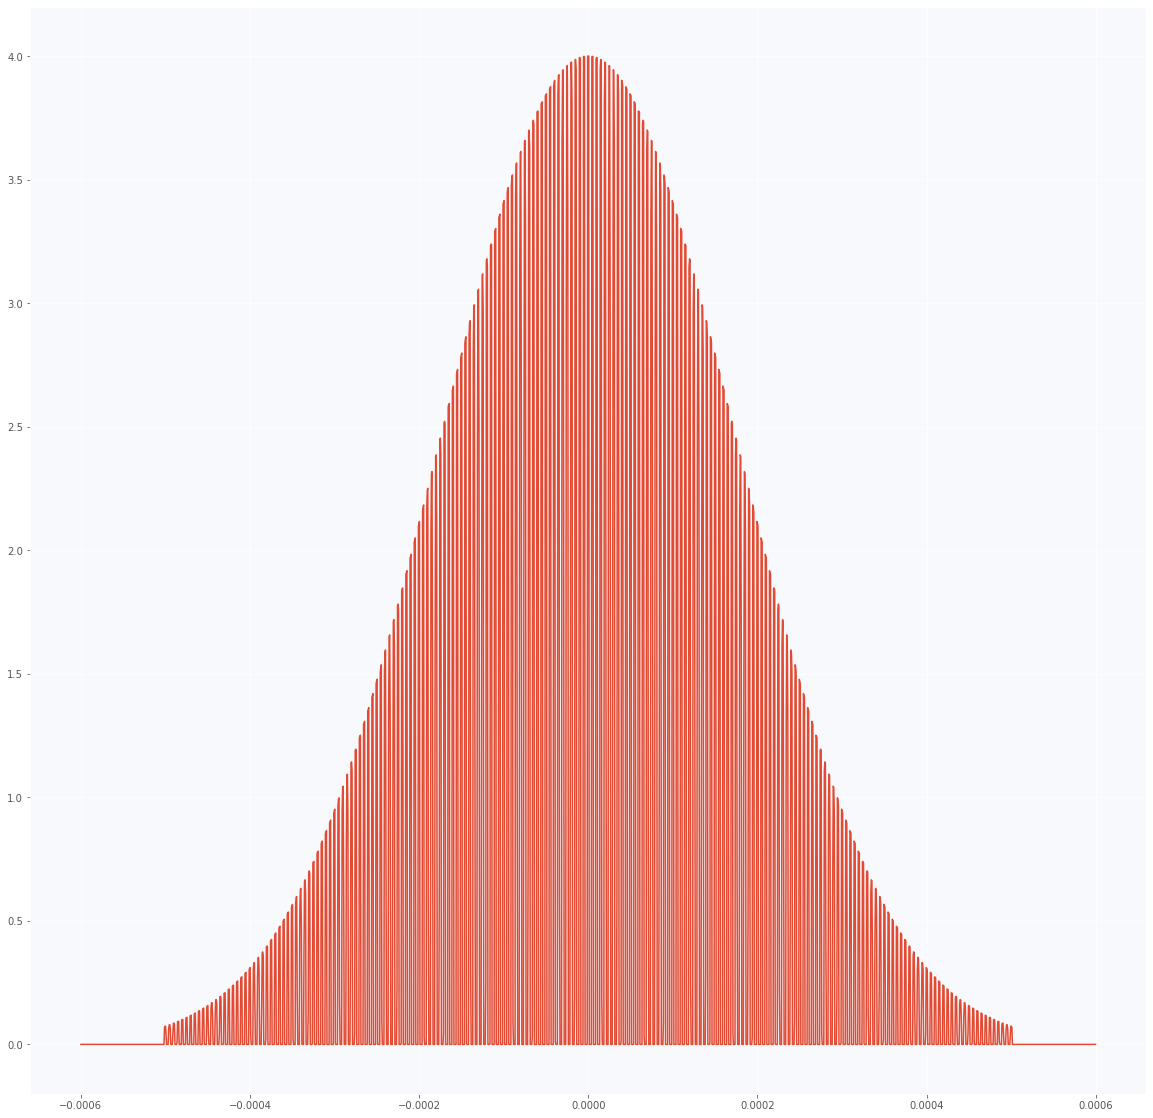

In [75]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.plot(cp.asnumpy(x[cp.abs(x)<6e-4]), cp.asnumpy(PlaneInputField[cp.abs(x)<6e-4]))

TypeError: ignored

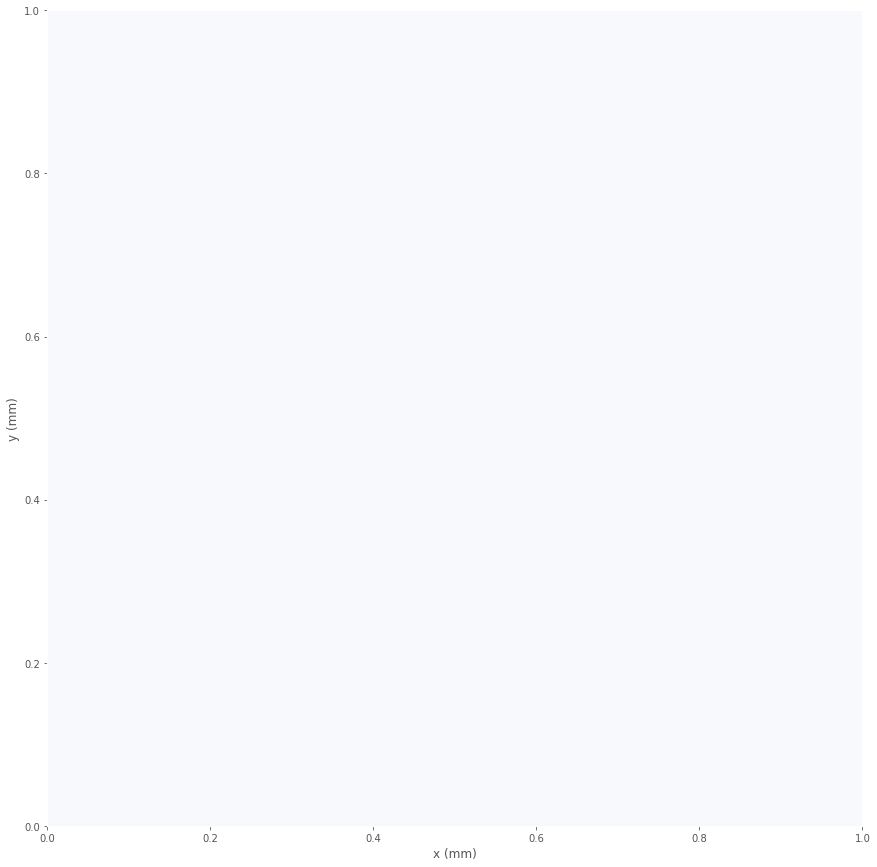

In [66]:
plot(PlaneInputField)

Lasted 1.0281884670257568 seconds
Lasted 0.9958562850952148 seconds


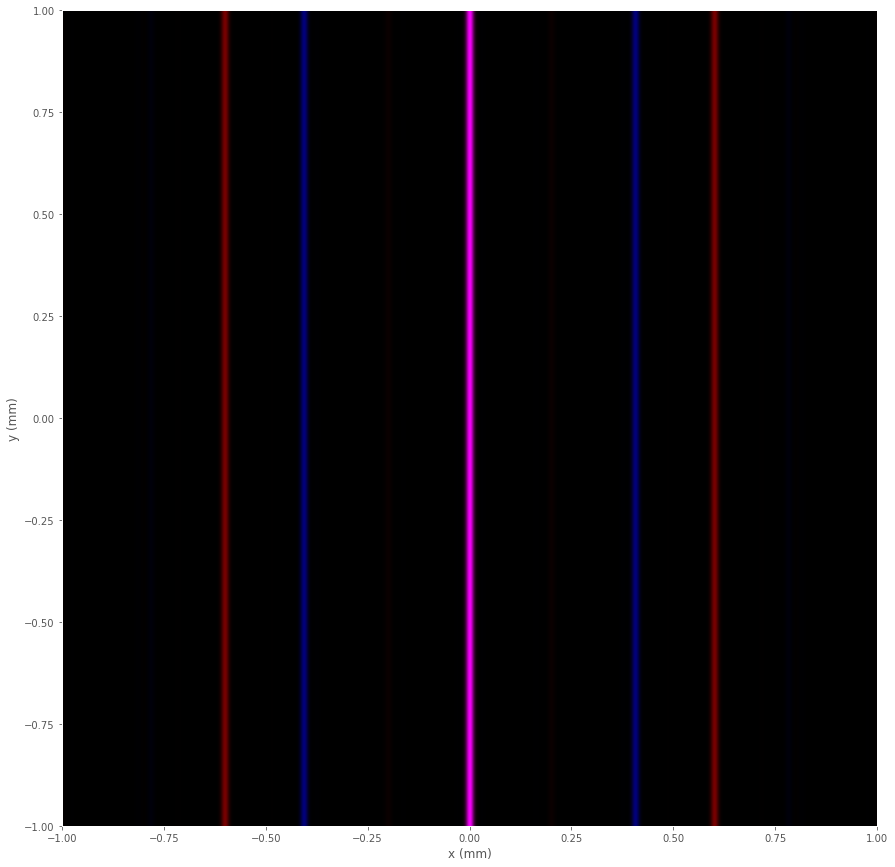

In [52]:
Red = propagate_and_get_rgb(PlaneInputField, 0.65e-6)
Blue = propagate_and_get_rgb(PlaneInputField, 0.44e-6)

fig, ax = plot((Red+Blue), width=1)
fig.savefig("4.png")

Lasted 1.0085411071777344 seconds
Lasted 1.0051655769348145 seconds


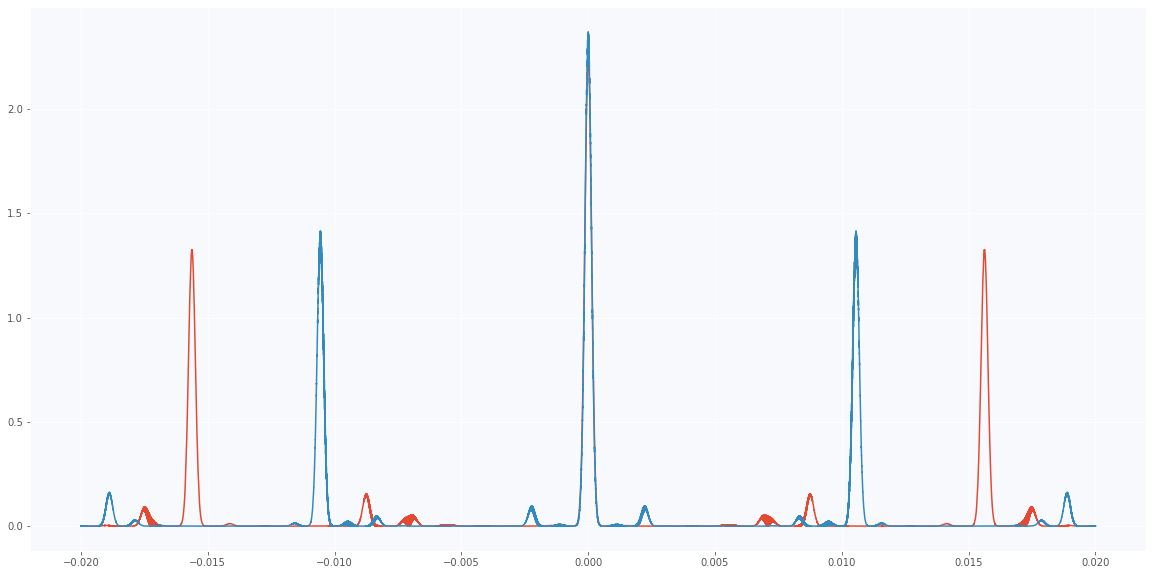

In [80]:
OutputField, FieldModuleMemory = propagate(PlaneInputField, k0)
intensity = np.abs(OutputField)**2
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(cp.asnumpy(x), cp.asnumpy(intensity))
OutputField, FieldModuleMemory = propagate(PlaneInputField, 2*np.pi/0.44e-6)

intensity = np.abs(OutputField)**2
ax.plot(cp.asnumpy(x), cp.asnumpy(intensity))

In [90]:
OutputField, FieldModuleMemory = propagate(PlaneInputField, 2*cp.pi/0.651e-6)
intensity1 = cp.abs(OutputField)**2


OutputField, FieldModuleMemory = propagate(PlaneInputField, 2*cp.pi/0.637e-6)

intensity2 = cp.abs(OutputField)**2

Lasted 1.0170588493347168 seconds
Lasted 1.029773473739624 seconds


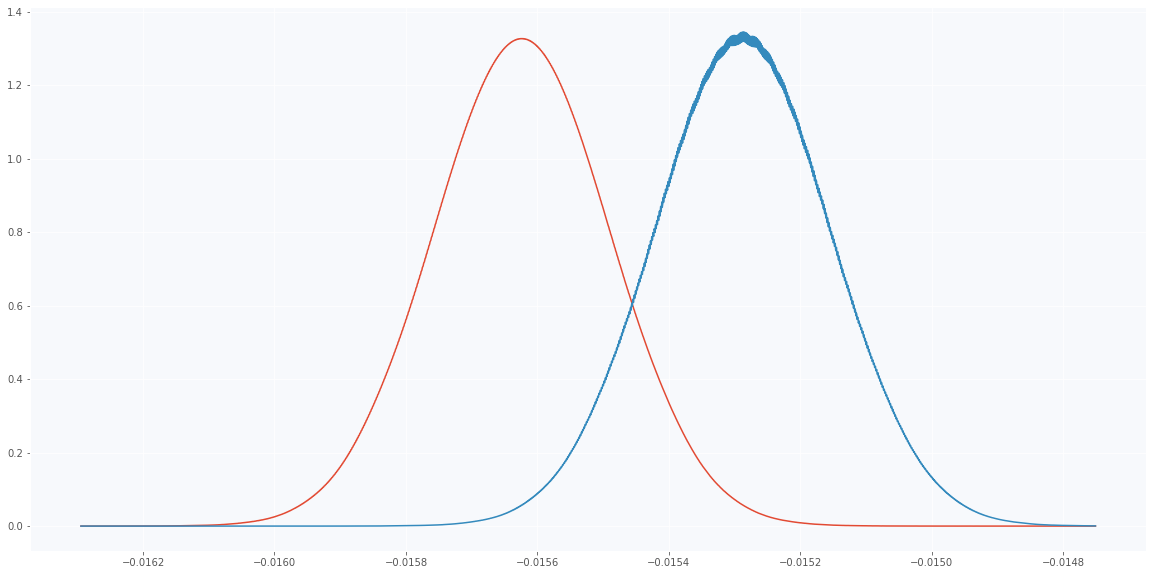

In [91]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(cp.asnumpy(x[6000:8500]), cp.asnumpy(intensity1[6000:8500]))
ax.plot(cp.asnumpy(x[6000:8500]), cp.asnumpy(intensity2[6000:8500]))

Guardando la figura, col criterio di Taylor possiamo stabilire che larghezza di risoluzione è circa di 0.014e-6m = 14nm per lunghezze d'onda rosse. Il resolving power è dunque: 0.651e-6/(0.014e-6) = 47.

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf9f9434a8>)

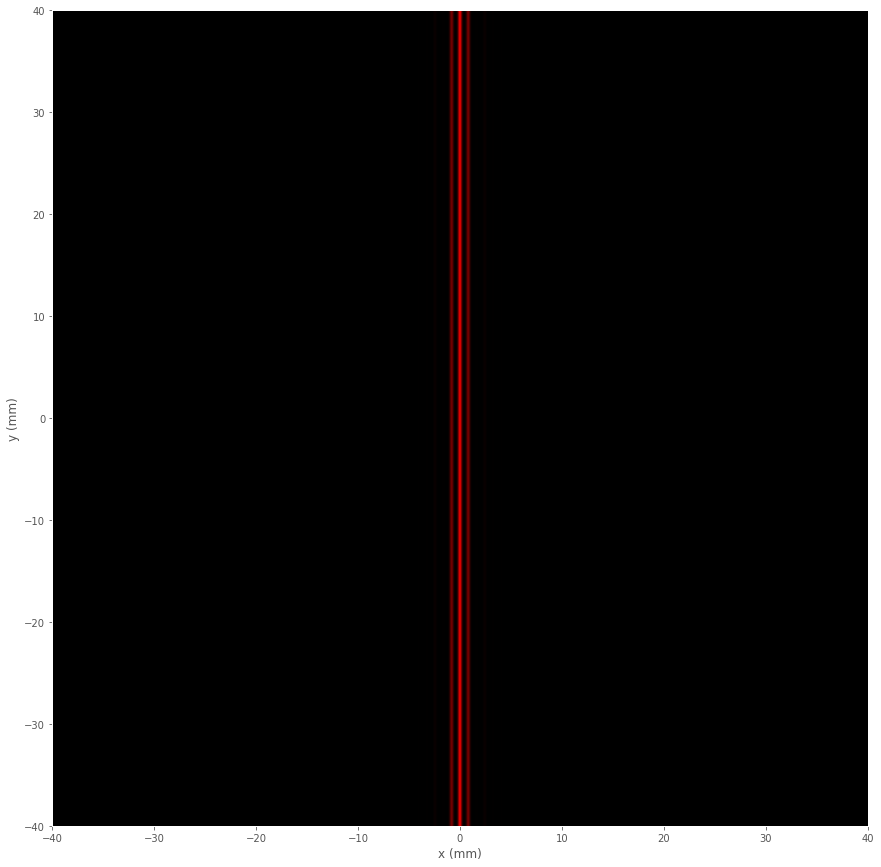

In [32]:
plot(np.stack((intensity,)*100, axis=0))

In [0]:
pl

In [76]:
output = cp.zeros((100, x.shape[0], 3))
wavelengths = np.linspace(400, 750, 7) # light with 7 colors
for wl in wavelengths:
 output += propagate_and_get_rgb(PlaneInputField, wl*1e-9)

Lasted 1.009793758392334 seconds
Lasted 1.0134778022766113 seconds
Lasted 1.0064821243286133 seconds
Lasted 1.0169849395751953 seconds
Lasted 1.0023341178894043 seconds
Lasted 0.9970450401306152 seconds
Lasted 1.0039429664611816 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


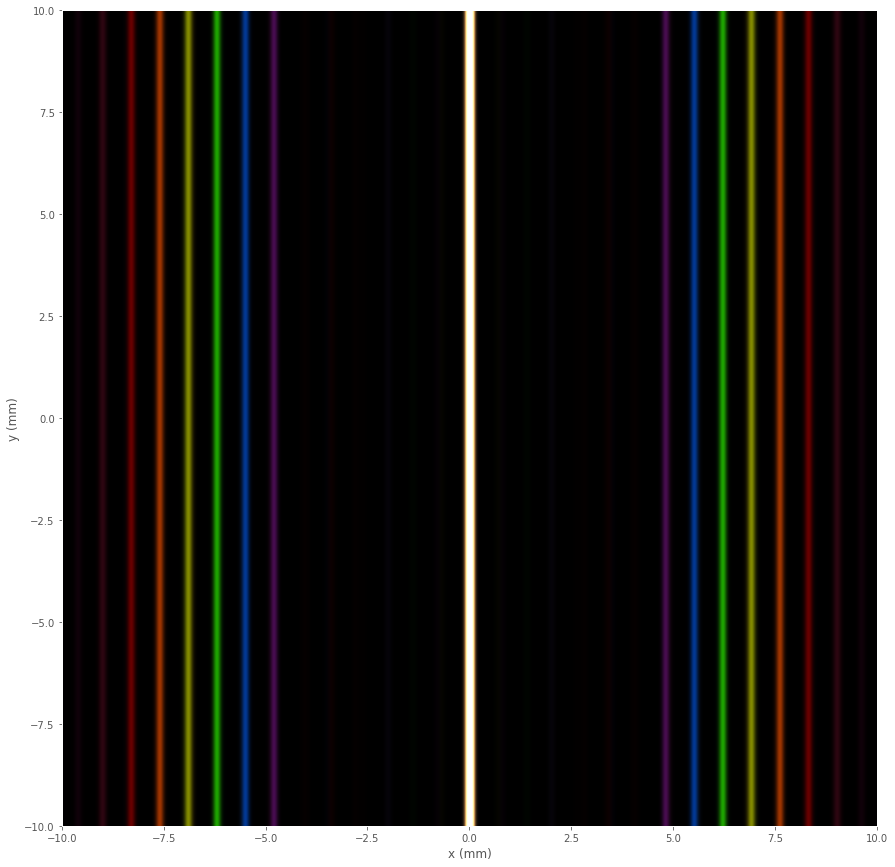

In [77]:
fig, ax = plot(output, width=10)
plt.xlabel("x (mm)")
plt.show()
fig.savefig("5.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


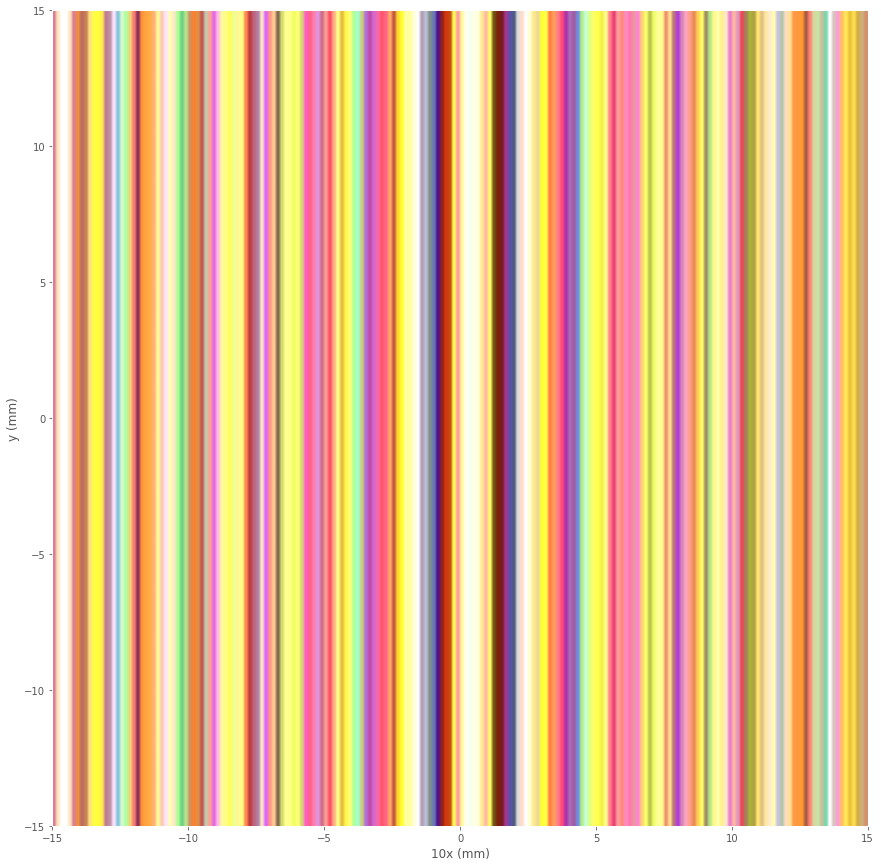

In [0]:
fig. ax = plot(output[:, 512-102:512+102])
plt.xlabel("10x (mm)")
plt.show()
fig.savefig("6.png")

In [92]:
output = cp.zeros(Red.shape)
wavelengths = np.linspace(380, 750, 40) # light with 7 colors
for wl in wavelengths:
 output += propagate_and_get_rgb(PlaneInputField, wl*1e-9)

Lasted 1.0187127590179443 seconds
Lasted 1.0127086639404297 seconds
Lasted 1.0301899909973145 seconds
Lasted 1.0166683197021484 seconds
Lasted 1.0069262981414795 seconds
Lasted 1.0018234252929688 seconds
Lasted 1.0003178119659424 seconds
Lasted 1.0087413787841797 seconds
Lasted 1.0035879611968994 seconds
Lasted 1.012470006942749 seconds
Lasted 1.0233886241912842 seconds
Lasted 1.0203335285186768 seconds
Lasted 1.0023016929626465 seconds
Lasted 1.007181167602539 seconds
Lasted 1.0086755752563477 seconds
Lasted 1.0000879764556885 seconds
Lasted 1.0009479522705078 seconds
Lasted 1.0306687355041504 seconds
Lasted 1.010033369064331 seconds
Lasted 1.0121827125549316 seconds
Lasted 1.0119011402130127 seconds
Lasted 1.000187873840332 seconds
Lasted 0.999483585357666 seconds
Lasted 1.0165002346038818 seconds
Lasted 1.0218865871429443 seconds
Lasted 1.0157434940338135 seconds
Lasted 1.007246732711792 seconds
Lasted 1.0390939712524414 seconds
Lasted 1.0088436603546143 seconds
Lasted 1.00439286231

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


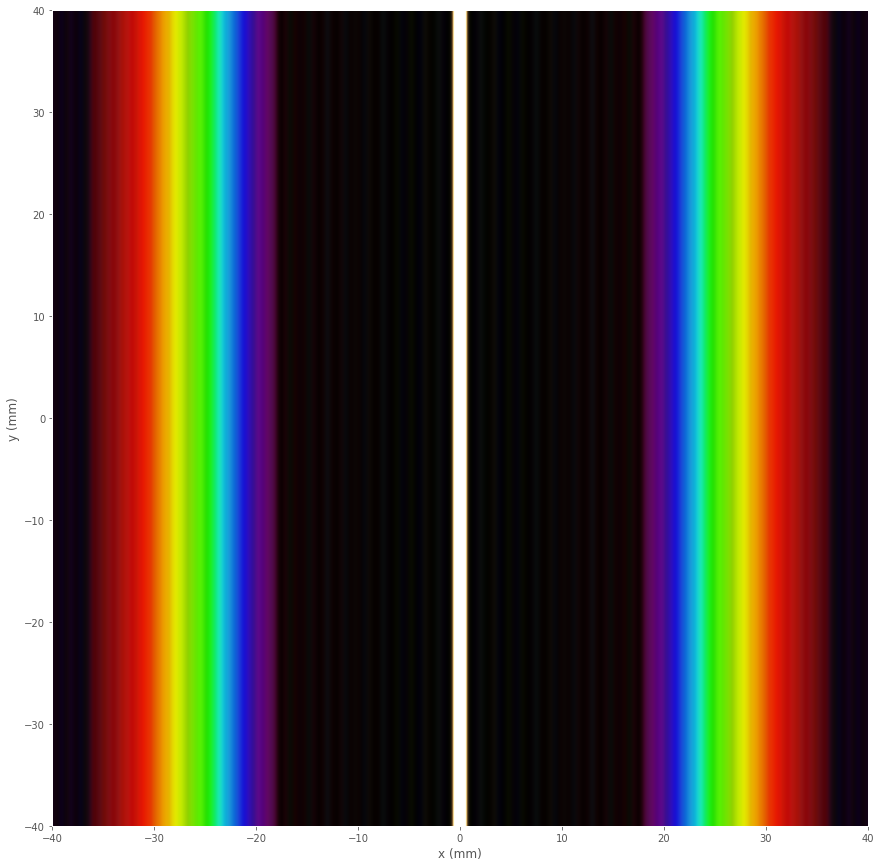

In [93]:
fig, ax = plot(output)
plt.xlabel("x (mm)")
plt.show()
fig.savefig("7.png")